# `snewpy.snowglobes` Usage Example

This notebook demonstrates how to use SNEWPY with SNOwGLoBES.

To start, make sure you have SNOwGLoBES installed and have downloaded one of the models that are part of SNEWPY. Adjust the directory paths in the following cell.

In [33]:
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from snewpy import snowglobes, model_path
from snewpy.models import Nakazato_2013, Bollig_2016, Zha_2021

SNOwGLoBES_path = None  # to use custom SNOwGLoBES detector/channel/smearing files, set SNOwGLoBES directory
SNEWPY_models_base = model_path  # directory containing SNEWPY models

/var/folders/3t/mf2g60fx3nb49wp30kcwr8300000gn/T/ipykernel_97914/955021736.py:6: FutureWarning: snewpy.models.Nakazato_2013 is moved to snewpy.models.ccsn.Nakazato_2013
  from snewpy.models import Nakazato_2013, Bollig_2016, Zha_2021
/var/folders/3t/mf2g60fx3nb49wp30kcwr8300000gn/T/ipykernel_97914/955021736.py:6: FutureWarning: snewpy.models.Bollig_2016 is moved to snewpy.models.ccsn.Bollig_2016
  from snewpy.models import Nakazato_2013, Bollig_2016, Zha_2021
/var/folders/3t/mf2g60fx3nb49wp30kcwr8300000gn/T/ipykernel_97914/955021736.py:6: FutureWarning: snewpy.models.Zha_2021 is moved to snewpy.models.ccsn.Zha_2021
  from snewpy.models import Nakazato_2013, Bollig_2016, Zha_2021


Next, we will set up some basic parameters for the supernova we want to simulate.

In [73]:
# set distance in kpc
distance = 10

# set SNOwGLoBES detector to use
detector = "icecube"

# set SNEWPY model type and filename
modeltype = 'Zha_2021'
model = 's17'

# set desired flavor transformation
transformation = 'AdiabaticMSW_NMO'

# Construct file system path of model file and name of output file
# The output file will be stored in the same directory as the model file.
modelfile = SNEWPY_models_base + "/" + modeltype + "/" + model + '.dat'
outfile = modeltype+"_"+model+"_"+transformation
print(modelfile)
print(type(modelfile))

# There are three ways to select a time range.
# Option 1 - don't specify tstart and tend, then the whole model is integrated
#tstart = None
#tend = None

# Option 2 - specify single tstart and tend, this makes 1 fluence file integrated over the window
#tstart = 0.7 * u.s
#tend = 0.8 * u.s

# Option 3 = specify sequence of time intervals, one fluence file is made for each interval

window_tstart = 0.742
window_tend = 0.762
window_bins = 100
tstart = np.linspace(window_tstart, window_tend, window_bins, endpoint=False) * u.s
tend = tstart + (window_tend - window_tstart) / window_bins * u.s


/Users/jannahelgendy/.astropy/cache/snewpy/models/Zha_2021/s17.dat
<class 'str'>


Now that everything’s set up, let’s start using SNOwGLoBES! Be patient—these three steps together may take a few minutes.

In [74]:
# snowglobes.generate_fluence integrates the model over the specified time window(s)
# and generates input files for SNOwGLoBES. It returns the full file path of the output file.
print("Preparing fluences ...")
tarredfile = snowglobes.generate_fluence(modelfile, modeltype, transformation, distance, outfile, tstart, tend)

# Next, we run SNOwGLoBES. This will loop over all the fluence files in `tarredfile`.
print("Running SNOwGLoBES ...")
snowglobes.simulate(SNOwGLoBES_path, tarredfile, detector_input=detector)

# Finally, we collate SNOwGLoBES’ results into a dictionary
print("Collating results ...")
tables = snowglobes.collate(SNOwGLoBES_path, tarredfile, skip_plots=True)

Preparing fluences ...


/Users/jannahelgendy/opt/anaconda3/lib/python3.9/site-packages/snewpy/snowglobes.py:140: FutureWarning: Initializing this model with a filename is deprecated. Instead, use keyword arguments ['progenitor_mass']. See `Zha_2021.param`, `Zha_2021.get_param_combinations()` for more info.
  snmodel = model_class(model_path, **snmodel_dict)


Running SNOwGLoBES ...
Using snowglobes_data module ...
Collating results ...


Finally, since we chose option 3 above, and calculated the fluence in 60 time bins, we can now plot the event counts over time.

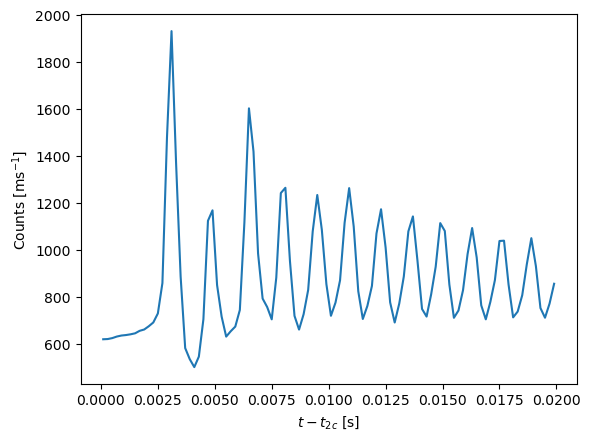

Total Events: 17531.20483397165


In [75]:
%matplotlib inline
nevents = np.zeros(len(tmid))
for i in range(len(tmid)):
    key = f"Collated_{outfile}_{i}_{detector}_events_smeared_weighted.dat"
    for j in range(1,len(tables[key]['header'].split())):
        nevents[i] += sum(tables[key]['data'][j])

# nevents is per bin, convert to per ms
factor = window_bins / (window_tend - window_tstart) / 1000

plt.plot(tmid - 0.742 * u.s, nevents * factor)
plt.xlabel("$t-t_{2c}$ [s]")
plt.ylabel("Counts [ms$^{-1}$]")
plt.show()
# compare to Figure 5 of Zha et al. (2021)
print("Total Events:", sum(nevents))